# Data Exploration

---

## Imports

In [1]:
import itertools
import json
import re
import string

import contractions
import emoji
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud

## Data Load 

In [2]:
complete = pd.read_parquet("../data/clean_data.parquet")

## EDA 

### Sentiment Distribution 

We see that there are 28 classes of emotion, and that the dataset is highly unbaleced

In [3]:
def plot_distribution(dataset: str = "complete", classification: str = "goemotion", top: int = 15) -> None:
    global labels_map
    
    fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

    count = (
        complete[classification].value_counts()
        .reset_index()
        .rename(columns={classification: "emotion", "mapping": "emotion", "count": "occurences"})
    )

    explode = (count["occurences"] / count["occurences"].sum()).to_list()[:top]
    labels = count["emotion"].to_list()[:top]
    ax2.pie(explode, explode=explode, startangle=60, labels=labels, autopct="%1.0f%%", normalize=False, pctdistance=0.9)
    ax2.add_artist(plt.Circle((0, 0), 0.6, fc="white"))

    sns.barplot(data=count, x="occurences", y="emotion", ax=ax1)

    ax1.set_title("Count of each emotion")
    ax2.set_title(f"Percentage of each emotion (top {top})", x=0.5, y=1.1)

    plt.show()

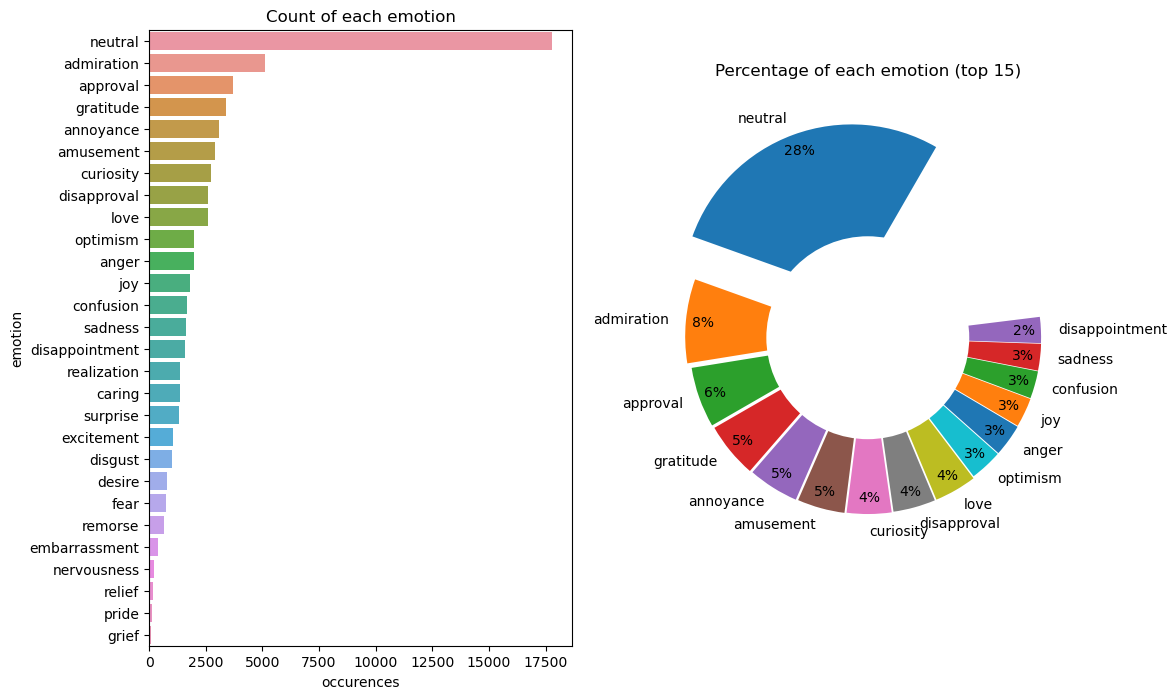

In [4]:
plot_distribution()

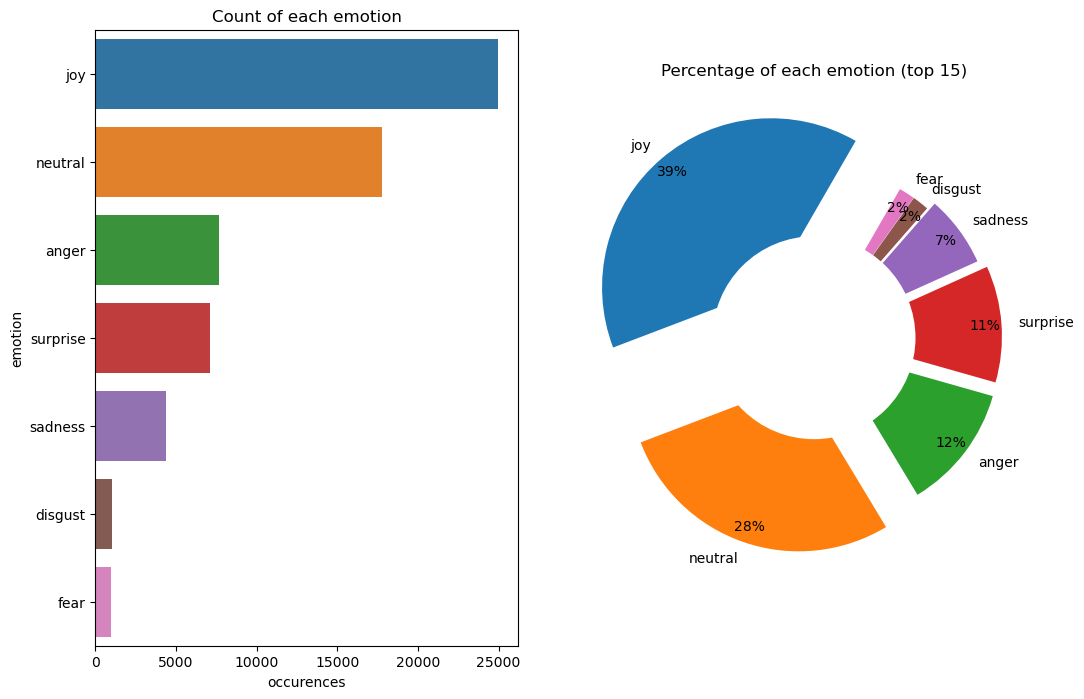

In [5]:
plot_distribution(classification="ekman")

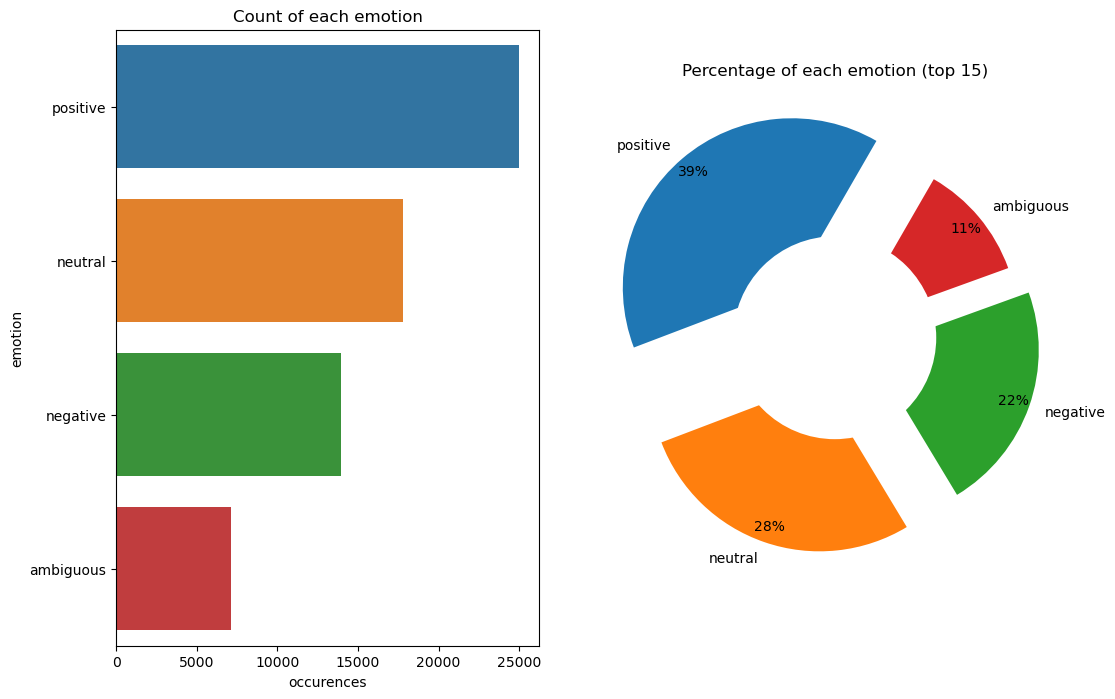

In [6]:
plot_distribution(classification="sentiment")

Moreover, we see that we have some data points where there are two emotions present. This represents 16% of the GoEmotions data. We can see from it that we have some pairs of emotions that are more common. For example, for sentences with a sadness emotion that have more than one emotion, it is very common to have it paired with grief.

In [ ]:
def plot_emotions_cooccurences(dataset: str = "complete", classification: str = "goemotion"):
    global labels_map
    
    df = complete.pivot_table(index="code", columns=classification, values="text", aggfunc="count", fill_value=0)
    ax = sns.countplot(df.sum(axis=1).reset_index(), y=0)
    ax.set_title("Number of setences by number of emotions present")
    print(
        "Data points with more than one emotion: %.1f%%" 
        % (100 * df.sum(axis=1).loc[lambda f: f > 1].shape[0] / df.shape[0])
    )

    matrix = pd.DataFrame(
        df.apply(lambda x: [df.columns[i] for i, v in enumerate(x.values) if v == 1], axis=1)
        .apply(lambda x: [tuple(set(c)) for c in itertools.combinations(x, 2)])
        .apply(lambda x: x + [(p2, p1) for p1, p2 in x])
        .sum(),
        columns=["emotion_1", "emotion_2"]
    ).assign(count=1).pivot_table(index="emotion_1", columns="emotion_2", values="count", aggfunc="sum", fill_value=0)

    plt.figure(figsize=(16, 10))
    matrix = matrix / matrix.sum(axis=1)
    ax = sns.heatmap(matrix, cmap="coolwarm")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    _ = ax.set_title("Emotions Co-occurances")

In [ ]:
plot_emotions_cooccurences()

In [ ]:
plot_emotions_cooccurences(classification="ekman")

In [ ]:
plot_emotions_cooccurences(classification="sentiment")

### Character and Token Length 

In [ ]:
extended = (
    complete.assign(char_length=lambda f: f['text'].apply(lambda x : len(x)))
    .assign(token_length=lambda f: f['text'].apply(lambda x : len(x.split(" "))))
)

The vast majority of our sentences have less than 200 characters, and have a maximum of 33 tokens

In [ ]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(extended['char_length'], ax=ax1)
sns.distplot(extended['token_length'], ax=ax2)
ax1.set_title('Number of characters in the sentence')
ax2.set_title('Number of token(words) in the sentence')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16 ,8))
for emotion in extended['goemotion'].value_counts().sort_values()[-10:].index.tolist():
    sns.kdeplot(extended[extended['goemotion']==emotion]['char_length'],ax=ax, label=emotion)
ax.legend()
ax.set_title("Distribution of character length sentiment-wise [Top 10 sentiments]")
plt.show()

In [ ]:
vc = extended['goemotion'].value_counts()
emotion_order = list(vc.index)

plt.figure(figsize=(15,8))

ax = sns.barplot(data=extended, x='goemotion', y='char_length', estimator=np.mean, order=emotion_order)
ax.set_xticklabels(emotion_order, rotation=90)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.2f'), 
        (p.get_x() + p.get_width() / 2., 
         p.get_height()), 
        ha = 'center', 
        va = 'center', 
        xytext = (0, -50), 
        textcoords = 'offset points'
    )

In [ ]:
vc = extended['goemotion'].value_counts()
emotion_order = list(vc.index)

plt.figure(figsize=(15,8))

ax = sns.barplot(data=extended, x='goemotion', y='token_length', estimator=np.mean, order=emotion_order)
ax.set_xticklabels(emotion_order, rotation=90)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.2f'), 
        (p.get_x() + p.get_width() / 2., 
         p.get_height()), 
        ha = 'center', 
        va = 'center', 
        xytext = (0, -50), 
        textcoords = 'offset points'
    )

### Word Cloud 

In [ ]:
complete.loc[lambda f: f["clean_text"].str.contains("\[EMOJI_")]

In [ ]:
emotions = complete["goemotion"].unique()
emotions = list(emotions)

fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(30, 16))

for ax, emotion in zip(axes.flatten(), emotions):
    text = " ".join(complete[complete["goemotion"] == emotion]["clean_text"])
    cloud = WordCloud(width=800, height=800, background_color="white", min_font_size=10).generate(text)
    ax.imshow(cloud)
    ax.set_title(emotion, fontsize=16)
    ax.axis("off")

plt.show()

---